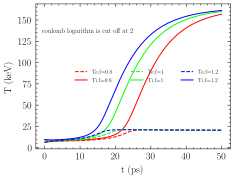

In [164]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scienceplots
import sys

# Define the constants
# All in SI units
A_alpha = 8e39 
m_e = 9.1*10**(-31) 
m_p= 1.637*10**(-27) 
m_i = 5*m_p
A_r = 8.95336*10**12 
A_e = 1.78455*10**(-10) 
A_omegaei = 1.90766*10**21 
kB = 1.381*10**(-23)
GammaB = 6600.87 
Rhoc = 3*10**5 
Cvi = 3/2*kB/m_i 
Cve = 3/2*kB/m_e 
cut_off=2

# Define the functions
def Th(Te,Ti):
    return (Te+Ti)/2 

def SigmaV(Ti):
    return 9.1*10**(-16)*np.exp(-0.572*np.abs(np.log(Ti/(64.2*11604525.0062)))**(2.4))*10**(-6)

def Rhoe(rho):
    return 2*m_e*rho/(5*m_p+2*m_e) # g/cm^3

def Rhoi(rho):
    return 5*m_p*rho/(5*m_p+2*m_e) # g/cm^3

def Ne(rho):
    return Rhoe(rho)/m_e # 10^21 cm^-3

def Ni(rho):
    return Rhoi(rho)/m_i # 10^21 cm^-3

def LnLambda(Te,rho):
    lnlambda = 7.1-0.5*np.log(Ne(rho)/(10^(27)))+np.log(Te/11604525.0062)
    if cut_off>0:
        lnlambda=max(lnlambda,cut_off)
    return lnlambda

def Taualpha(Te,Ti,rho,Rh):
    th = Th(Te,Ti)
    lnLambda = LnLambda(Te,rho)
    return 45*lnLambda/5*rho*1000*Rh/(th/11604525.0062)**(3/2)

def f_alpha(Te,Ti,rho,Rh):
    tau = Taualpha(Te,Ti,rho,Rh)
    if tau<=1/2:
        return 3/2*tau-4/5*tau**2
    else:
        return 1-1/(4*tau)+1/(160*tau**3)

def W_alpha(Te,Ti,rho,Rh):
    sigmav = SigmaV(Ti)
    falpha = f_alpha(Te,Ti,rho,Rh)
    return A_alpha*Rhoi(rho)**2*sigmav*falpha

def f_alphai(Te):
    return Te/(Te+32*11604525.0062)

def f_alphae(Te):
    return 32*11604525.0062/(Te+32*11604525.0062)

def W_r(rho, Te):
    return A_r*rho**2*np.sqrt(Te)

def W_e(Te, Ti,rho, Rh):
    lnlambda = LnLambda(Te,rho)
    # th = Th(Te,Ti)
    return A_e*3*Te**(7/2)/(lnlambda*Rh**2)

def W_ie(Te, Ti, rho):
    lnlambda = LnLambda(Te,rho)
    return A_omegaei*lnlambda*rho**2*(-Te+Ti)/Te**(3/2)

def P_e(Te, rho):
    ne = Ne(rho)
    return ne*kB*Te

def P_i(Ti, rho):
    ni = Ni(rho)
    return ni*kB*Ti

def Uh(Te, Ti, rho):
    th = Th(Te,Ti)
    return (3/4*GammaB*th*rho/Rhoc)**(1/2)*4*10**(-15)

def W_mi(Te, Ti, rho, Rh):
    uh = Uh(Te, Ti, rho)
    pi = P_i(Ti, rho)
    return 3*pi*uh/Rh

def W_me(Te, Ti, rho, Rh):
    uh = Uh(Te, Ti, rho)
    pe = P_e(Te, rho)
    return 3*pe*uh/Rh

def Vh(Rh):
    return 4*np.pi/3*Rh**3


# Debug
def printall(y):
    Te = y[0]
    Ti = y[1]
    rho = y[2]
    Rh = y[3]
    Walpha = W_alpha(y[0],y[1],y[2],y[3])
    falpha = f_alpha(y[0],y[1],y[2],y[3])
    Wme = W_me(y[0],y[1],y[2],y[3])
    Wmi = W_mi(y[0],y[1],y[2],y[3])
    We = W_e(y[0],y[1],y[2],y[3])
    Wr = W_r(y[2],y[0])
    Wie = W_ie(y[0],y[1],y[2])
    falphai = f_alphai(y[0])
    falphae = f_alphae(y[0])
    vh = Vh(y[3])
    uh = Uh(y[0],y[1],y[2])
    print(falpha, falphae, Walpha*falphae+Wie-Wme-Wr-We, Cve*rho, (Walpha*falphae+Wie-Wme-Wr-We)/(Cve*rho)/Te*10**(-12))


# Define the differential equations
# y = [Te,Ti,rho,Rh]
def model(y, t):
    # dydt2 = 1/(Cvi*Rhoi(y[2]))*(W_alpha(y[0],y[1],y[2],y[3])*f_alphai(y[0])-W_ie(y[0],y[1],y[2])-W_mi(y[0],y[1],y[2],y[3]))
    # dydt1 = 1/(Cve*Rhoe(y[2]))*(W_alpha(y[0],y[1],y[2],y[3])*f_alphae(y[0])+W_ie(y[0],y[1],y[2])-W_me(y[0],y[1],y[2],y[3])-W_r(y[2],y[0])-W_e(y[0],y[1],y[2],y[3]))
    Walpha = W_alpha(y[0],y[1],y[2],y[3])
    falpha = f_alpha(y[0],y[1],y[2],y[3])
    Wme = W_me(y[0],y[1],y[2],y[3])
    Wmi = W_mi(y[0],y[1],y[2],y[3])
    We = W_e(y[0],y[1],y[2],y[3])
    Wr = W_r(y[2],y[0])
    Wie = W_ie(y[0],y[1],y[2])
    falphai = f_alphai(y[0])
    falphae = f_alphae(y[0])
    vh = Vh(y[3])
    uh = Uh(y[0],y[1],y[2])
    # print(Walpha, falpha, Wme, Wmi, We)#, Wr, Wie, falphai, falphae, vh, uh)
    dydt2 = 1/(Cvi*Rhoi(y[2]))*(Walpha*falphai-Wie-Wmi)
    dydt1 = 1/(Cve*Rhoe(y[2]))*(Walpha*falphae+Wie-Wme-Wr-We)
    dydt3 = (((Wr+We+Walpha*(1-falpha)/falpha)*vh)/(Cvi*y[1]+Cve*y[0])-4*np.pi*y[3]**2*y[2]*uh)/vh
    dydt4 = uh
    if np.isnan(y[0]):
        print("Te is nan")
        sys.exit()
    if np.isnan(y[1]):
        print("Ti is nan")
        sys.exit()
    if np.isnan(y[2]):
        print("rho is nan")
        sys.exit()
    if np.isnan(y[3]):
        print("Rh is nan")
        sys.exit()
    # print(dydt1, dydt2, dydt3, dydt4)
    return [dydt1, dydt2, dydt3, dydt4]


# Simulate the model
def Simulate(f,c):
    # Set up the initial conditions
    Th0 = 8*11604525.0062 
    Ti0 = Th0*f # keV
    Te0 = Th0*(2-f) # keV
    rho0 = 120*10**3 # g/cm^3
    Rh0 = 30*10**(-6) # cm
    y0 = [Te0, Ti0, rho0, Rh0]
    t = np.linspace(0, 50*10**(-12), 10000)
    # tt = t[1]-t[0]
    # Y =[]
    # Y.append(y0)
    # for time in t[0:-1]:
    #     y = Y[-1]
    #     dydt = model(y, tt)
    #     y2 = [y[0]+dydt[0]*tt, y[1]+dydt[1]*tt, y[2]+dydt[2]*tt, y[3]+dydt[3]*tt]
    #     Y.append(y2)
    #     # print(y2)

    # Ti = []
    # Te = []
    # for y in Y:
    #     Ti.append(y[1]/11604525.0062)
    #     Te.append(y[0]/11604525.0062)
    # Call the odeint function
    y = odeint(model, y0, t)
    # for y in Y:
    #     printall(y)
    # print(y[:, 0])
    # Print the solution
    for i in range(2):
        num = len(y[:, i])
        for j in range(num):
            y[j,i] = y[j,i]/11604525.0062
    t = [tt*10**12 for tt in t]   
    # plt.plot(t, Te, label='Te,f='+str(f))
    # plt.plot(t, Ti, label='Ti,f='+str(f))
    plt.plot(t, y[:,0], label='Te,f='+str(f),linestyle='--',color=c)
    plt.plot(t, y[:,1], label='Ti,f='+str(f),linestyle='-',color=c)
    plt.xlabel('t (ps)')
    plt.ylabel('T (keV)')
    plt.legend(loc='best', ncol=3)
    plt.rc('legend', fontsize=6) 
    # plt.show()

# Plot the results
with plt.style.context('science'):
    Simulate(0.8,[1,0,0])
    Simulate(1,[0,1,0])
    Simulate(1.2,[0,0,1])
    if cut_off>0:
            plt.annotate( 'coulomb logarithm is cut off at '+str(cut_off),xy=(0, 1), xycoords='axes fraction',xytext=(0.03, 0.8),fontsize=7)
    else:
            plt.annotate( 'coulomb logarithm is not cut off ',xy=(0, 1), xycoords='axes fraction',xytext=(0.03, 0.8),fontsize=7)
    plt.show()

/var/folders/w4/y0jybgrd6334d4jt8d45_fx00000gn/T/ipykernel_684/2843004978.py:17: RuntimeWarning: divide by zero encountered in log
  lnlambda = np.maximum(7.1-0.5*np.log(Ne(rho)/(10^(27)))+np.log(Te/11604525.0062),[cutoff]*len(Te))
/var/folders/w4/y0jybgrd6334d4jt8d45_fx00000gn/T/ipykernel_684/697408458.py:28: RuntimeWarning: divide by zero encountered in log
  return 9.1*10**(-16)*np.exp(-0.572*np.abs(np.log(Ti/(64.2*11604525.0062)))**(2.4))*10**(-6)
/var/folders/w4/y0jybgrd6334d4jt8d45_fx00000gn/T/ipykernel_684/2843004978.py:25: RuntimeWarning: invalid value encountered in divide
  rhor=(3*A_e*(2-f)**3.5*T_h**3.5/(LnLambda(T_e,rho0,cut_off)*(A_alpha*SigmaV(T_i)*f*T_h-A_r*(2-f)**0.5*T_h**0.5)))**0.5
/var/folders/w4/y0jybgrd6334d4jt8d45_fx00000gn/T/ipykernel_684/2843004978.py:25: RuntimeWarning: invalid value encountered in sqrt
  rhor=(3*A_e*(2-f)**3.5*T_h**3.5/(LnLambda(T_e,rho0,cut_off)*(A_alpha*SigmaV(T_i)*f*T_h-A_r*(2-f)**0.5*T_h**0.5)))**0.5


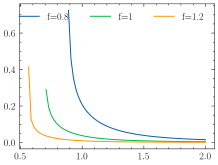

In [155]:
rho0 = 120*10**3 # g/cm^3
Rh0 = 30*10**(-6) # cm
A_alpha = 8e39 
m_e = 9.1*10**(-31) 
m_p= 1.637*10**(-27) 
m_i = 5*m_p
A_r = 8.95336*10**12 
A_e = 1.78455*10**(-10) 
A_omegaei = 1.90766*10**21 
kB = 1.381*10**(-23)
GammaB = 6600.87 
Rhoc = 3*10**5 
Cvi = 3/2*kB/m_i 
Cve = 3/2*kB/m_e 
cut_off=1
def LnLambda(Te,rho,cutoff):
    lnlambda = np.maximum(7.1-0.5*np.log(Ne(rho)/(10^(27)))+np.log(Te/11604525.0062),[cutoff]*len(Te))
    #if cut_off>0:
     #   lnlambda=max(lnlambda,cut_off)
    return lnlambda

def condition(T_h,f):
    T_e = T_h*(2-f)
    T_i = T_h*f 
    rhor=(3*A_e*(2-f)**3.5*T_h**3.5/(LnLambda(T_e,rho0,cut_off)*(A_alpha*SigmaV(T_i)*f*T_h-A_r*(2-f)**0.5*T_h**0.5)))**0.5
    plt.plot(T_h/11604525.0062, rhor,label='f='+str(f))
    plt.legend(loc='best', ncol=3)
Th = np.linspace(0 ,2, 100)*11604525.0062
with plt.style.context('science'):
    condition(Th,0.8)
    condition(Th,1)
    condition(Th,1.2)
    plt.show()